In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build the Model

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the GAN and Inspect Output

11493376/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.027177, acc.: 100.00%] [G loss: 5.440748]
2000 [D loss: 0.074986, acc.: 97.66%] [G loss: 6.262749]
3000 [D loss: 0.175693, acc.: 92.97%] [G loss: 5.043686]
4000 [D loss: 0.275100, acc.: 91.41%] [G loss: 3.869479]
5000 [D loss: 0.185146, acc.: 91.02%] [G loss: 6.064243]
6000 [D loss: 0.320042, acc.: 88.67%] [G loss: 4.486097]
7000 [D loss: 0.365550, acc.: 86.33%] [G loss: 3.468210]
8000 [D loss: 0.136913, acc.: 94.53%] [G loss: 4.756678]
9000 [D loss: 0.370889, acc.: 81.25%] [G loss: 2.416614]
10000 [D loss: 0.267969, acc.: 87.50%] [G loss: 4.578892]
11000 [D loss: 0.315875, acc.: 87.89%] [G loss: 3.573228]
12000 [D loss: 0.226816, acc.: 89.84%] [G loss: 3.440603]
13000 [D loss: 0.264268, acc.: 88.67%] [G loss: 3.086545]
14000 [D loss: 0.248480, acc.: 89.84%] [G loss: 3.394711]
15000 [D loss: 0.546945, acc.: 72.66%] [G loss: 2.393379]
16000 [D loss: 0.539534, acc.: 73.05%] [G loss: 2.468175]
17000 [D loss: 

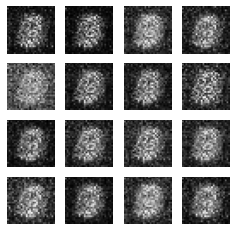

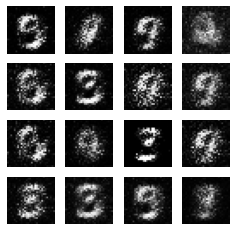

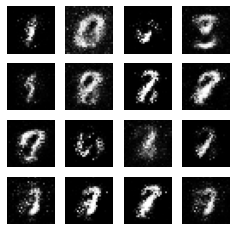

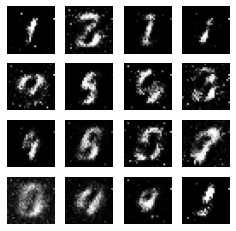

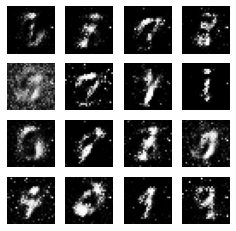

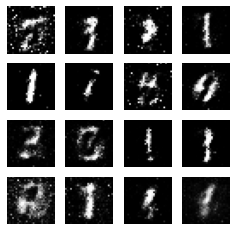

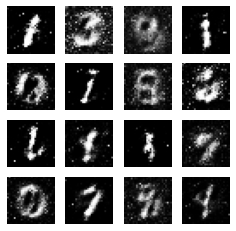

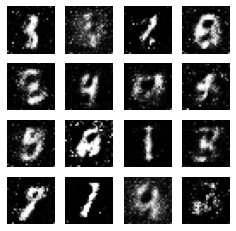

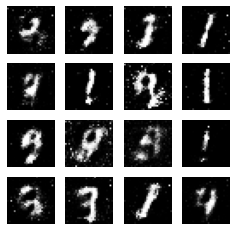

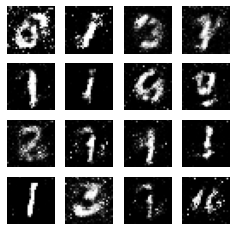

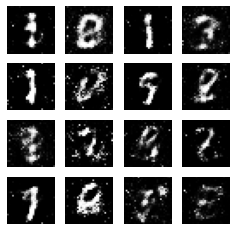

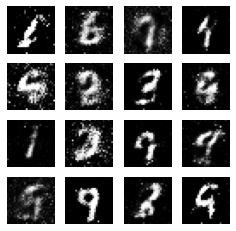

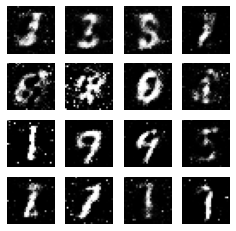

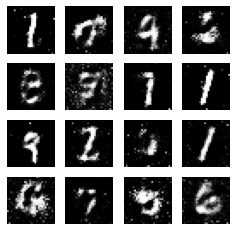

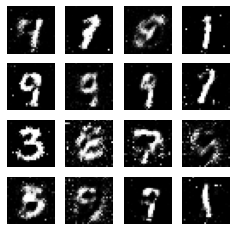

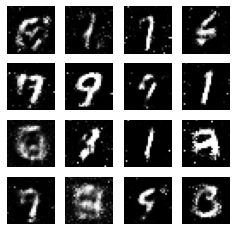

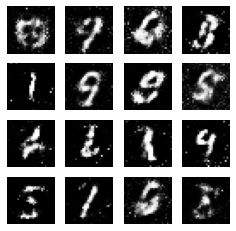

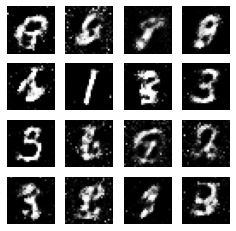

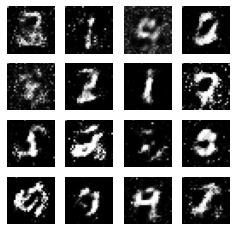

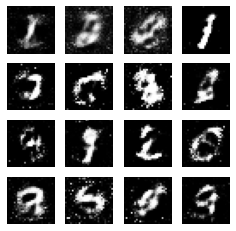

In [9]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

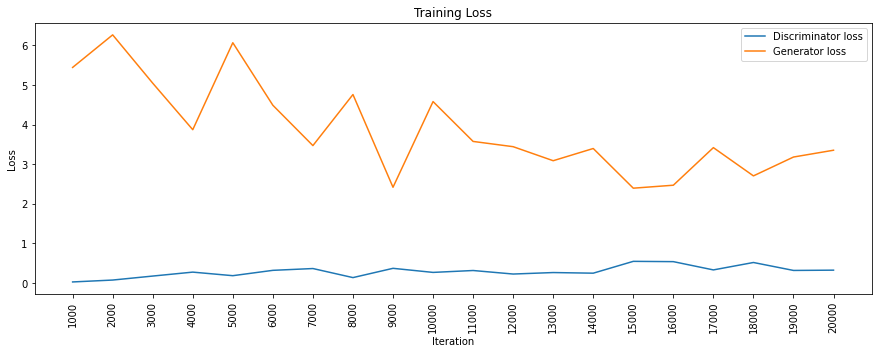

In [10]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

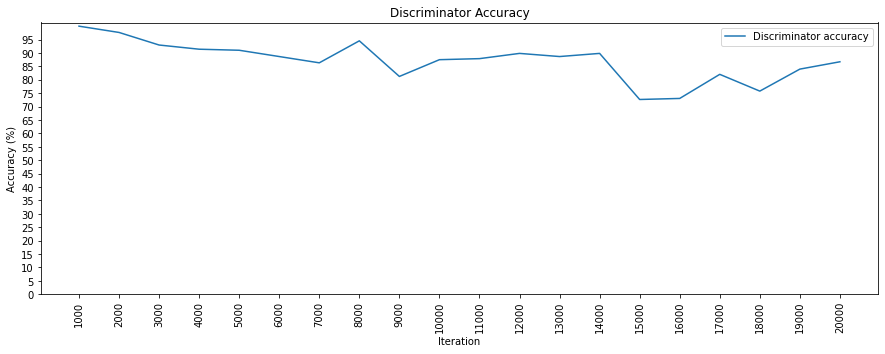

In [11]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

----